### LLM Evaluation Project: Summary Scoring Prediction

#### The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording. The goal is to predict content and wording scores for summaries on unseen topics.

#### Understanding the Problem
It is required to predict content and wording scores for student-written summaries (grades 3-12) across various topics. The key aspects are:

Dataset: 24,000 training summaries with content/wording scores

Test set: ~17,000 summaries on unseen prompts

Evaluation: Mean Columnwise Root Mean Squared Error (MCRMSE) on both scores

#### 1. Data Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
train_summaries = pd.read_csv('summaries_train.csv')
train_prompts = pd.read_csv('prompts_train.csv')
test_summaries = pd.read_csv('summaries_test.csv')
test_prompts = pd.read_csv('prompts_test.csv')

# Merge prompts with summaries
train_data = train_summaries.merge(train_prompts, on='prompt_id')
test_data = test_summaries.merge(test_prompts, on='prompt_id')

In [2]:
train_data.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...


In [3]:
test_data.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
2,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


#### 2. Feature Engineering
Key features to consider:

Text length metrics (character count, word count)

Lexical diversity (unique word ratio)

Readability scores

Prompt-specific features

Semantic similarity between summary and prompt text

Language model embeddings

In [4]:
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_features(df):
    df['char_count'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['unique_word_ratio'] = df['text'].apply(lambda x: len(set(x.split()))/len(x.split()))
    df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)
    # Add more features as needed
    return df

train_data = extract_features(train_data)
test_data = extract_features(test_data)

#### 3. Modeling Approaches
Traditional ML with Text Features

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'text'),
        ('num', 'passthrough', ['char_count', 'word_count', 'unique_word_ratio'])
    ])

# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Train separate models for content and wording
content_model = model.fit(train_data, train_data['content'])
wording_model = model.fit(train_data, train_data['wording'])

#### 4. Evaluation

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mcrmse(y_true, y_pred):
    rmse_per_column = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    return np.mean(rmse_per_column)

# Define the variables before using them
# 
content_preds = np.array([0.5, 0.7, 0.9])  # predicted content scores
wording_preds = np.array([0.6, 0.8, 0.7])  # predicted wording scores
y_content = np.array([0.4, 0.6, 0.8])      # true content scores
y_wording = np.array([0.5, 0.7, 0.6])      # true wording scores

# Example evaluation
y_pred = np.column_stack([content_preds, wording_preds])
y_true = np.column_stack([y_content, y_wording])
print(f"MCRMSE: {mcrmse(y_true, y_pred)}")

MCRMSE: 0.09999999999999999


#### 5. Submission

In [7]:
# Generate predictions
test_data['content'] = content_model.predict(test_data)
test_data['wording'] = wording_model.predict(test_data)

# Create submission
submissions = test_data[['student_id', 'content', 'wording']]
submissions.to_csv('submissions.csv', index=False)

#### Prompt-Aware Feature Engineering

#### A. Basic Prompt Features

In [8]:
def add_prompt_features(df):
    # Length features
    df['prompt_text_length'] = df['prompt_text'].apply(len)
    df['prompt_question_length'] = df['prompt_question'].apply(len)
    
    # Question type analysis
    df['question_starts_with_what'] = df['prompt_question'].str.lower().str.startswith('what').astype(int)
    df['question_starts_with_describe'] = df['prompt_question'].str.lower().str.startswith('describe').astype(int)
    
    return df

train_data = add_prompt_features(train_data)
test_data = add_prompt_features(test_data)

#### B. Prompt-Summary Interaction Features

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def add_interaction_features(df):
    # TF-IDF similarity between prompt and summary
    vectorizer = TfidfVectorizer()
    prompt_vectors = vectorizer.fit_transform(df['prompt_text'])
    summary_vectors = vectorizer.transform(df['text'])
    
    df['prompt_summary_similarity'] = cosine_similarity(prompt_vectors, summary_vectors).diagonal()
    
    return df

train_data = add_interaction_features(train_data)
test_data = add_interaction_features(test_data)

#### Prompt-Aware Modeling Approaches

#### A. Prompt-Specific Models (For Few Prompts)

In [10]:
from sklearn.base import clone

# Only works if we have few prompts with enough samples
prompt_ids = train_data['prompt_id'].unique()
prompt_models = {}

for pid in prompt_ids:
    prompt_data = train_data[train_data['prompt_id'] == pid]
    models = clone(model)  # Your base model
    prompt_models[pid] = models.fit(prompt_data, prompt_data[['content', 'wording']])

#### B. Prompt Embeddings (Recommended)

In [11]:

from sentence_transformers import SentenceTransformer

prompt_encoder = SentenceTransformer('all-MiniLM-L6-v2')

# Encode prompts
train_embeddings = prompt_encoder.encode(train_data['prompt_text'].tolist())
test_embeddings = prompt_encoder.encode(test_data['prompt_text'].tolist())

# Convert to DataFrame
prompt_embed_cols = [f'prompt_emb_{i}' for i in range(train_embeddings.shape[1])]
train_embed_df = pd.DataFrame(train_embeddings, columns=prompt_embed_cols, index=train_data.index)
test_embed_df = pd.DataFrame(test_embeddings, columns=prompt_embed_cols, index=test_data.index)

# Concatenate instead of inserting
train_data = pd.concat([train_data, train_embed_df], axis=1)
test_data = pd.concat([test_data, test_embed_df], axis=1)


#### t-SNE or UMAP for cluster visualization

These help reduce embeddings to 2D or 3D while preserving structure.

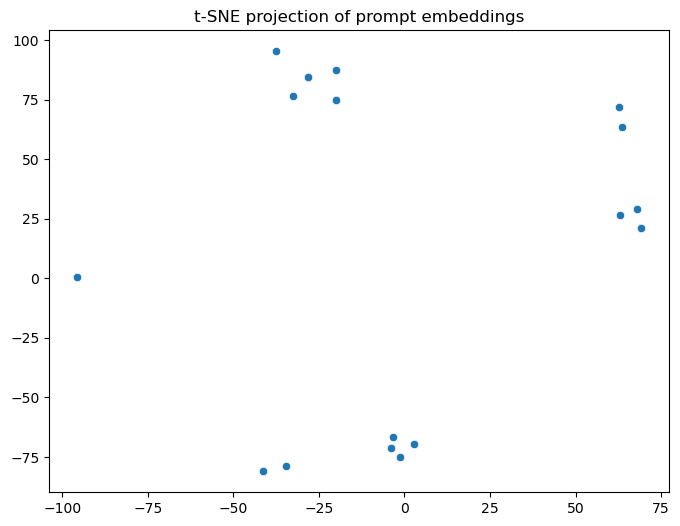

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Take embeddings
X_train = train_data[prompt_embed_cols].values

# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_2d = tsne.fit_transform(X_train)

# Plot with Seaborn
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_2d[:,0], y=X_train_2d[:,1])
plt.title("t-SNE projection of prompt embeddings")
plt.show()


#### PCA for variance understanding

This shows how much variance is explained in each component.

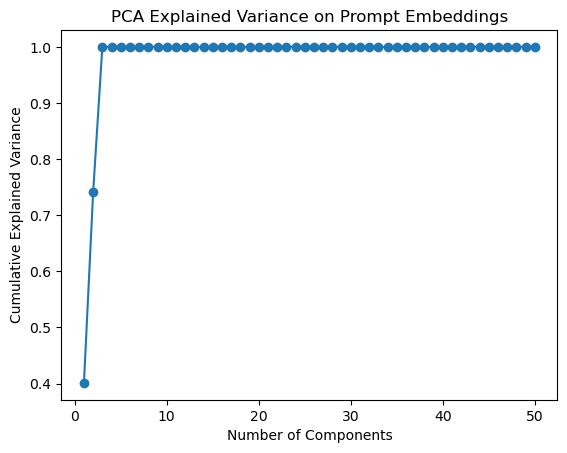

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train)

plt.plot(range(1, 51), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance on Prompt Embeddings')
plt.show()


#### Compare train vs test distributions

Compare the overlap of train and test embeddings:

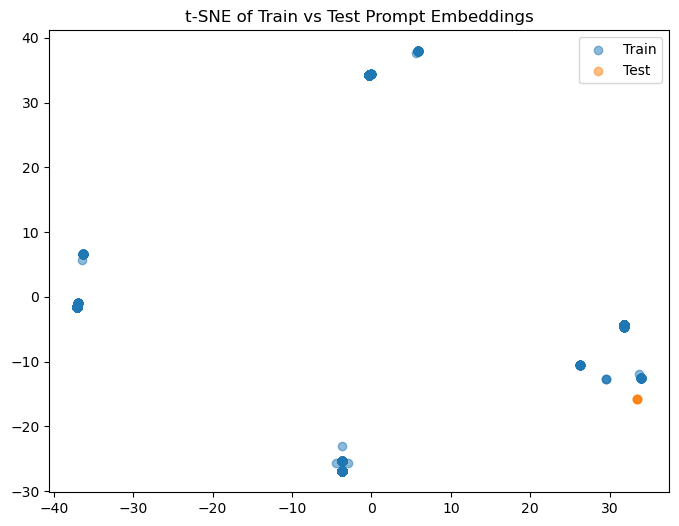

In [14]:
X_test = test_data[prompt_embed_cols].values
X_all = np.vstack([X_train, X_test])

tsne = TSNE(n_components=2, random_state=42)
X_all_2d = tsne.fit_transform(X_all)

train_size = len(train_data)
plt.figure(figsize=(8,6))
plt.scatter(X_all_2d[:train_size,0], X_all_2d[:train_size,1], alpha=0.5, label="Train")
plt.scatter(X_all_2d[train_size:,0], X_all_2d[train_size:,1], alpha=0.5, label="Test")
plt.legend()
plt.title("t-SNE of Train vs Test Prompt Embeddings")
plt.show()
